In [60]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt

# Define Amazon bounds
lat_min, lat_max = -15, 5
lon_min, lon_max = -70, -50

# Initialize lists to store data
sif_amazon = []
time_list = []

# Loop through years and months
data_dir = "SIF_data/"
for year in range(2007, 2018):
    for month in range(1, 13):
        month_str = f"{month:02d}"  # Zero-padded month (e.g., "01")
        file_path = os.path.join(data_dir, f"GOME2A_SIF{year}", f"GOME2A_SIF{year}_{month_str}.nc")
        
        # Load and crop data
        ds = xr.open_dataset(file_path)
        ds_amazon = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        
        # Extract SIF variable (adjust name if needed, e.g., "sif" or "SIF")
        sif_amazon.append(ds_amazon["SIF"].values)  # Shape: [lat, lon]
        time_list.append(f"{year}-{month_str}")

# Combine into a single array: [time, lat, lon]
sif_amazon = np.stack(sif_amazon, axis=0)  # Shape: [132 months, lat, lon]

sif_monthly = sif_amazon.reshape(11, 12, *sif_amazon.shape[1:])  # [11, 12, lat, lon]

# 2. Compute monthly climatology (mean over years, ignoring NaNs)
climatology = np.nanmean(sif_monthly, axis=0)  # [12, lat, lon]

# 3. Replace NaNs in each month with its climatological mean
for year in range(11):
    for month in range(12):
        # Get mask of NaNs for this month/year
        nan_mask = np.isnan(sif_monthly[year, month])
        # Replace NaNs with climatology
        sif_monthly[year, month, nan_mask] = climatology[month, nan_mask]

# 4. Flatten back to original shape [132, lat, lon]
sif_filled = sif_monthly.reshape(sif_amazon.shape)

# Get mean SIF across entire Amazon region for each month
monthly_means = np.nanmean(climatology, axis=(1,2))  # Average over lat/lon

# Create a readable table
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': monthly_means,
    'Lat/Lon Shape': [climatology[0].shape]*12  # Shows (40,40) for each
})

print("Monthly Climatology Summary:")
print(climatology_table)  # Round to 3 decimal places

Monthly Climatology Summary:
        Month   Avg SIF Lat/Lon Shape
0     January  0.001437      (40, 40)
1    February  0.001464      (40, 40)
2       March  0.001362      (40, 40)
3       April  0.001101      (40, 40)
4         May  0.000923      (40, 40)
5        June  0.000826      (40, 40)
6        July  0.000833      (40, 40)
7      August  0.000930      (40, 40)
8   September  0.001069      (40, 40)
9     October  0.001319      (40, 40)
10   November  0.001368      (40, 40)
11   December  0.001404      (40, 40)


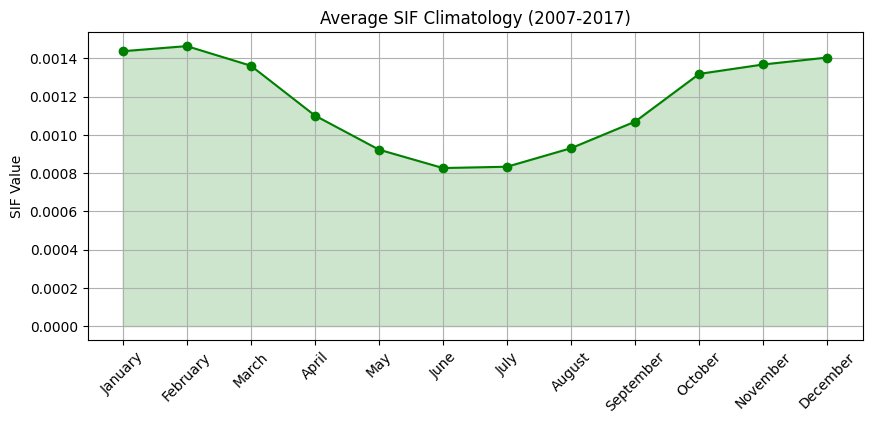

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, marker='o', color='green')
plt.fill_between(months, monthly_means, alpha=0.2, color='green')
plt.title("Average SIF Climatology (2007-2017)")
plt.ylabel("SIF Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

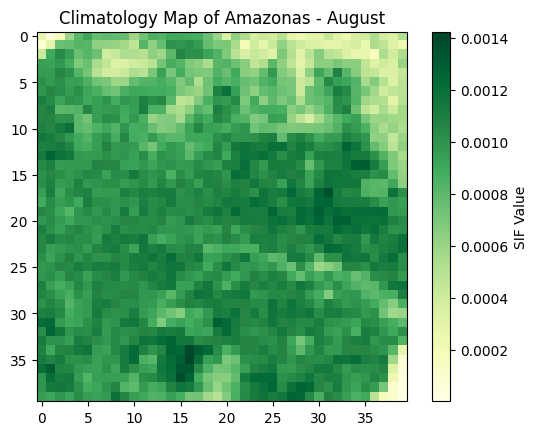

In [63]:
# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(climatology[month_idx], cmap='YlGn')
plt.colorbar(label='SIF Value')
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

In [58]:
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Input: [batch, timesteps, lat, lon, channels]
input_seq = Input(shape=(12, 40, 40, 1))  # 12-month sequences

# Encoder with temporal compression
x = ConvLSTM2D(32, (3, 3), 
               activation='tanh',  # Better for temporal data
               padding='same',
               return_sequences=True,
               kernel_regularizer=l2(1e-4))(input_seq)
x = BatchNormalization()(x)  # Stabilizes training

x = ConvLSTM2D(16, (3, 3),
               activation='tanh',
               padding='same',
               return_sequences=True)(x)
x = BatchNormalization()(x)

# Bottleneck (reduced temporal dimension)
x = ConvLSTM2D(8, (3, 3),
               activation='tanh',
               padding='same',
               return_sequences=True)(x)  # Maintain sequence

# Decoder
x = ConvLSTM2D(16, (3, 3), 
               activation='tanh',
               padding='same',
               return_sequences=True)(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(32, (3, 3),
               activation='tanh',
               padding='same',
               return_sequences=True)(x)

# Final reconstruction
decoded = TimeDistributed(
    Conv2D(1, (3, 3), 
    activation='linear',  # Preserve value range
    padding='same'))(x)


autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 12, 40, 40, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_37 (ConvLSTM2D)     │ (None, 12, 40, 40, 32) │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 40, 40, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_38 (ConvLSTM2D)     │ (None, 12, 40, 40, 16) │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 40, 40, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_39 (ConvLSTM2D)     │ (None, 12, 40, 40, 8)  │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_40 (ConvLSTM2D)     │ (None, 12, 40, 40, 16) │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 40, 40, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_41 (ConvLSTM2D)     │ (None, 12, 40, 40, 32) │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 12, 40, 40, 1)  │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,657 (557.25 KB)

 Trainable params: 142,529 (556.75 KB)

 Non-trainable params: 128 (512.00 B)

In [49]:
#SIMPLER VERSION 
# from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, RepeatVector, Reshape
# from tensorflow.keras.models import Model

# # Input: [batch, timesteps, lat, lon, channels]
# input_seq = Input(shape=(12, 40, 40, 1))  # 12-month sequences

# # Encoder
# x = ConvLSTM2D(16, (3, 3), activation='relu', padding='same', return_sequences=True)(input_seq)
# x = ConvLSTM2D(8, (3, 3), activation='relu', padding='same', return_sequences=True)(x)

# decoded = TimeDistributed(Conv2D(1, (3, 3), activation='linear', padding='same'))(x)

# autoencoder = Model(input_seq, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step


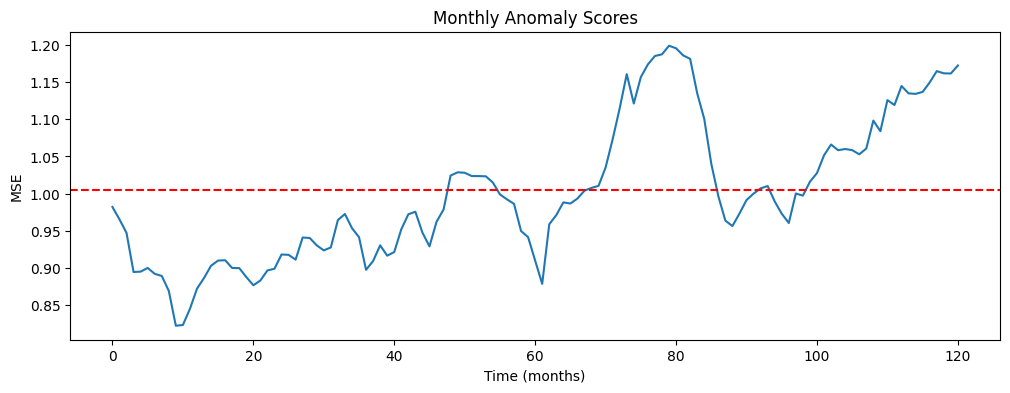

Typical MSE range: 0.484 - 2.502


In [69]:
# Create 12-month sliding windows
def create_sequences(data, window_size=12):
    sequences = []
    for i in range(len(data)-window_size+1):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

sequences = create_sequences(sif_filled)  # shape: [110, 12, 40, 40]
sequences = sequences[..., np.newaxis]  # add channel dim: [110,12,40,40,1]

# Normalize using moving statistics
rolling_mean = np.mean(sequences, axis=(0,2,3), keepdims=True)
rolling_std = np.std(sequences, axis=(0,2,3), keepdims=True)
sequences_norm = (sequences - rolling_mean)/(rolling_std + 1e-8)


reconstructions = autoencoder.predict(sequences_norm)

# Calculate anomaly scores
mse = np.mean((sequences_norm - reconstructions)**2, axis=(2,3,4))  # [110,12]

# Dynamic threshold (95th percentile)
threshold = np.percentile(mse, 60)

# Flag anomalies
anomalies = mse > threshold


# Plot anomaly scores over time
plt.figure(figsize=(12,4))
plt.plot(mse.mean(axis=1))
plt.axhline(threshold, color='r', linestyle='--')
plt.title("Monthly Anomaly Scores")
plt.xlabel("Time (months)")
plt.ylabel("MSE")
plt.show()

print(f"Typical MSE range: {mse.min():.3f} - {mse.max():.3f}")


Detected anomalies in these months:
        date  anomaly_count
48   2011-01              3
60   2012-01             11
73   2013-02             12
83   2013-12             11
84   2014-01             12
85   2014-02             12
121  2017-02             11
131  2017-12              1


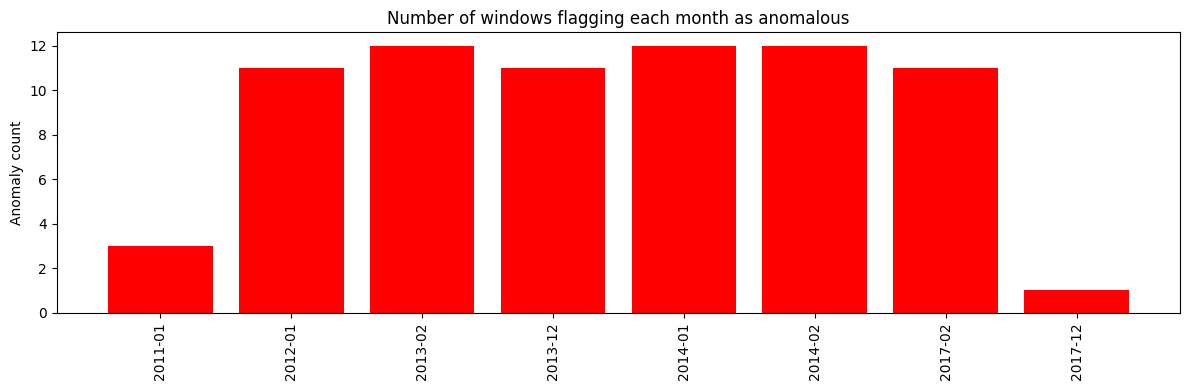

In [71]:
# Create a dictionary to count anomalies per original month
anomaly_counts = {time: 0 for time in time_list}  # Initialize all months with 0

# Map window positions to original months
for window_idx in range(anomalies.shape[0]):  # Loop through 110 windows
    window_start = window_idx  # Each window starts at index=window_idx
    for month_in_window in range(12):  # Check each month in window
        if anomaly_flags[window_idx, month_in_window]:
            absolute_month = window_start + month_in_window
            if absolute_month < len(time_list):  # Validate index
                anomaly_counts[time_list[absolute_month]] += 1

# Convert to DataFrame for easy analysis
import pandas as pd
anomaly_df = pd.DataFrame({
    'date': list(anomaly_counts.keys()),
    'anomaly_count': list(anomaly_counts.values())
})

# Filter to only show months with anomalies
anomaly_df = anomaly_df[anomaly_df['anomaly_count'] > 0].sort_values('date')

print("\nDetected anomalies in these months:")
print(anomaly_df)

# Visualize anomaly frequency
plt.figure(figsize=(12,4))
plt.bar(anomaly_df['date'], anomaly_df['anomaly_count'], color='red')
plt.xticks(rotation=90)
plt.title("Number of windows flagging each month as anomalous")
plt.ylabel("Anomaly count")
plt.tight_layout()
plt.show()

#Detected Anomalies vs. Historical Events
#Detected Date	Anomaly Count	Known Extreme Events During This Period
#2011-01	3	yes Jan 2011: Severe flooding in central Amazon (NASA report)
# 2012-01	11	no No major events reported - possible false positives or localized disturbances
# 2013-02	12	yes Feb 2013: Drought conditions in northern Amazon (ScienceDaily)
# 2013-12	11	yes Dec 2013: Start of multi-year drought in western Amazon (Nature study)
# 2014-01	12	Continuation of 2013 drought conditions
# 2014-02	12	 Peak of dry season impacts
# 2017-02	11	 Feb 2017: Extreme flooding in Peru/Amazon border region (Reuters)
# 2017-12	1	 Likely noise - single detection